Self-Organizing Maps (Kohonen Network)

In [3]:
import numpy as np
import matplotlib.pyplot as plt


Epoch 0/500
Epoch 100/500
Epoch 200/500
Epoch 300/500
Epoch 400/500


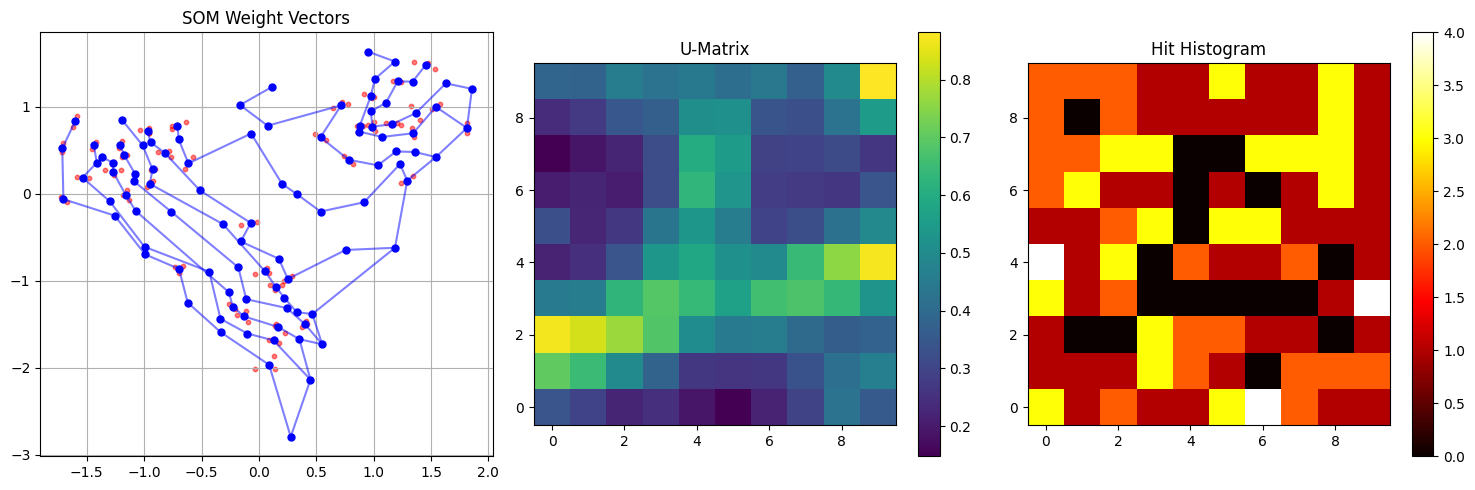

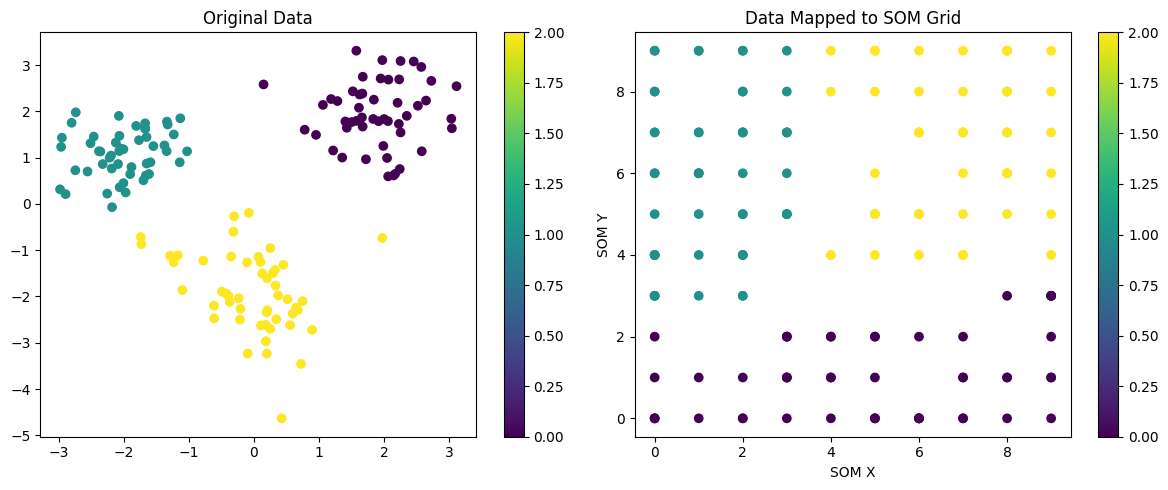

In [4]:
class SOM:
    def __init__(self, width: int, height: int, input_dim: int, learning_rate: float = 0.5, neighborhood_radius: float = None):
        self.width = width
        self.height = height
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.neighborhood_radius = neighborhood_radius or max(width, height) / 2

        self.weights = np.random.random((width, height, input_dim))

        self.coordinates = np.array([[i, j] for i in range(width) for j in range(height)])

    def get_bmu(self, sample):
        distances = np.sum((self.weights - sample) ** 2, axis=2)
        bmu_idx = np.unravel_index(np.argmin(distances), distances.shape)
        return bmu_idx
    
    def neighborhood_function(self, distance, radius):
        return np.exp(-(distance ** 2) / (2 * radius ** 2))
    
    def update_weights(self, sample, bmu_idx, itr, total_itr):
        """Update weights using SOM learning rule"""
        #Decay learning rate and neighborhood radius
        current_learning_rate = self.learning_rate * (1 - itr / total_itr)
        current_radius = self.neighborhood_radius * (1 - itr / total_itr)

        #calculate distances from BMU
        bmu_coord = np.array(bmu_idx)
        for i in range(self.width):
            for j in range(self.height):
                node_coord = np.array([i, j])
                distance = np.linalg.norm(node_coord - bmu_coord)

                #Update if within beighborhood
                if distance <= current_radius:
                    influence = self.neighborhood_function(distance, current_radius)
                    self.weights[i, j] += (current_learning_rate * influence * (sample - self.weights[i, j]))

    def train(self, data, epochs: int):
        """Train the SOM"""
        n_samples = len(data)
        for epoch in range(epochs):
            for itr in range(n_samples):
                sample = data[np.random.randint(0, n_samples)]
                bmu_idx = self.get_bmu(sample)
                self.update_weights(sample, bmu_idx, epoch * n_samples + itr, epochs * n_samples)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}/{epochs}")

    def map_data(self, data):
        """Map data to SOM Grid"""
        mapped = np.zeros((len(data), 2))
        for i, sample in enumerate(data):
            bmu_idx = self.get_bmu(sample)
            mapped[i] = bmu_idx
        return mapped
    
    def get_u_matrix(self):
        """Calculate unified distance matrix"""
        u_matrix = np.zeros((self.width, self.height))

        for i in range(self.width):
            for j in range(self.height):
                neighbors = []

                for di in [-1, 0, 1]:
                    for dj in [-1, 0, 1]:
                        ni, nj = i + di, j + dj
                        if 0 <= ni < self.width and 0 <= nj < self.height and (di != 0 or dj != 0):
                            neighbors.append(self.weights[ni, nj])
                
                if neighbors:
                    distances = [np.linalg.norm(self.weights[i, j] - neighbor) for neighbor in neighbors]
                    u_matrix[i, j] = np.mean(distances)
        return u_matrix
    
    def visualize_som(self, data=None, labels=None):
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        if self.input_dim == 2:
            axs[0].set_title('SOM Weight Vectors')
            for i in range(self.width):
                for j in range(self.height):
                    axs[0].plot(self.weights[i, j, 0], self.weights[i, j, 1], 'bo', markersize=5)
                    if i < self.width - 1:
                        axs[0].plot([self.weights[i, j, 0], self.weights[i+1, j, 0]], [self.weights[i, j, 1], self.weights[i+1, j, 1]], 'b-', alpha=0.5)
                    elif j < self.height - 1:
                        axs[0].plot([self.weights[i, j, 0], self.weights[i, j+1, 0]], [self.weights[i, j, 1], self.weights[i, j+1, 1]], 'b-', alpha=0.5)
            if data is not None:
                axs[0].scatter(data[:, 0], data[:, 1], c='red', alpha=0.5, s=10)
            axs[0].grid(True)

        u_matrix = self.get_u_matrix()
        im1 = axs[1].imshow(u_matrix.T, cmap='viridis', origin='lower')
        axs[1].set_title('U-Matrix')
        plt.colorbar(im1, ax=axs[1])

        if data is not None:
            hit_histogram = np.zeros((self.width, self.height))
            for sample in data:
                bmu_idx = self.get_bmu(sample)
                hit_histogram[bmu_idx] += 1

            im2 = axs[2].imshow(hit_histogram.T, cmap='hot', origin='lower')
            axs[2].set_title('Hit Histogram')
            plt.colorbar(im2, ax=axs[2])

        plt.tight_layout()
        plt.show()

def generate_som_data():
    np.random.seed(42)

    cluster1 = np.random.multivariate_normal([2, 2], [[0.5, 0], [0, 0.5]], 50)
    cluster2 = np.random.multivariate_normal([-2, 1], [[0.3, 0.1], [0.1, 0.3]], 50)
    cluster3 = np.random.multivariate_normal([0, -2], [[0.4, -0.1], [-0.1, 0.6]], 50)

    data = np.vstack([cluster1, cluster2, cluster3])
    labels = np.hstack([np.zeros(50), np.ones(50), np.ones(50)*2])

    return data, labels

 # Generate data
data, labels = generate_som_data()

# Normalize data
data_normalized = (data - np.mean(data, axis=0)) / np.std(data, axis=0)

# Create and train SOM
som = SOM(width=10, height=10, input_dim=2, learning_rate=0.5)
som.train(data_normalized, epochs=500)

# Visualize results
som.visualize_som(data_normalized, labels)

# Map data to SOM grid
mapped_data = som.map_data(data_normalized)

plt.figure(figsize=(12, 5))

# Original data
plt.subplot(1, 2, 1)
scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
plt.title('Original Data')
plt.colorbar(scatter)

# Mapped data
plt.subplot(1, 2, 2)
scatter = plt.scatter(mapped_data[:, 0], mapped_data[:, 1], c=labels, cmap='viridis')
plt.title('Data Mapped to SOM Grid')
plt.colorbar(scatter)
plt.xlabel('SOM X')
plt.ylabel('SOM Y')

plt.tight_layout()
plt.show()